# ポアソン回帰手法

## 一般化線形モデル
一般化線形モデルとは，確率分布とリンク関数を指定することで，線形回帰モデルを一般化したものです．

入力$x$と出力$y$，出力の確率分布$p(y|\theta)$のパラメータを$\theta$とします．リンク関数$g(\cdot)$を指定することでモデル化できます．

### ポアソン回帰モデル
ポアソン回帰モデルは，ポアソン分布を確率分布として指定した一般化線形モデルです．
$$
y|\lambda \sim Poisson(\lambda) \\
\lambda = g^{-1}(\theta) = \exp(\theta) = \exp(\omega^T x)
$$

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

/home/mori/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.62
Date:                Mon, 03 Jul 2023   Deviance:                       121.52
Time:                        14:20:17   Pearson chi2:                     116.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7916
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2150      0.131      1.639      0.1

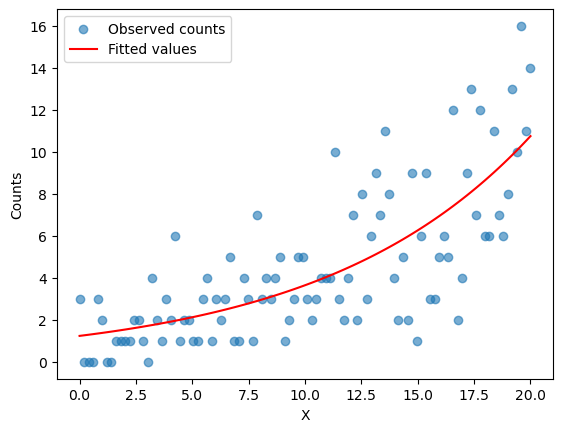

In [3]:
# 乱数のシードを固定
np.random.seed(42)

# データを生成
n_samples = 100
x = np.linspace(0, 20, n_samples)
# ポアソン分布の平均λ (lambda) を決定するための線形式を選びます
# ここでは lambda = exp(0.3 + 0.1 * x) を使用
lambda_ = np.exp(0.3 + 0.1 * x)
# ポアソン分布からランダムにデータをサンプリング
y = np.random.poisson(lambda_)

# データフレームにまとめる
data = pd.DataFrame({'x': x, 'y': y})

# ポアソン回帰モデルの設定
X = sm.add_constant(data['x'])  # 切片を追加
poisson_model = sm.GLM(data['y'], X, family=sm.families.Poisson())

# モデルのフィッティング
poisson_results = poisson_model.fit()

# 結果の表示
print(poisson_results.summary())

# プロット
plt.scatter(x, y, label='Observed counts', alpha=0.6)
plt.plot(x, poisson_results.mu, color='red', label='Fitted values')
plt.xlabel('X')
plt.ylabel('Counts')
plt.legend()
plt.show()

## ベイズポアソン回帰
上のポアソン回帰モデルに事前分布を導入したものがベイズポアソン回帰です．

手始めに，事前分布として正規分布を導入します．

/tmp/ipykernel_1694483/965606826.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
/home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


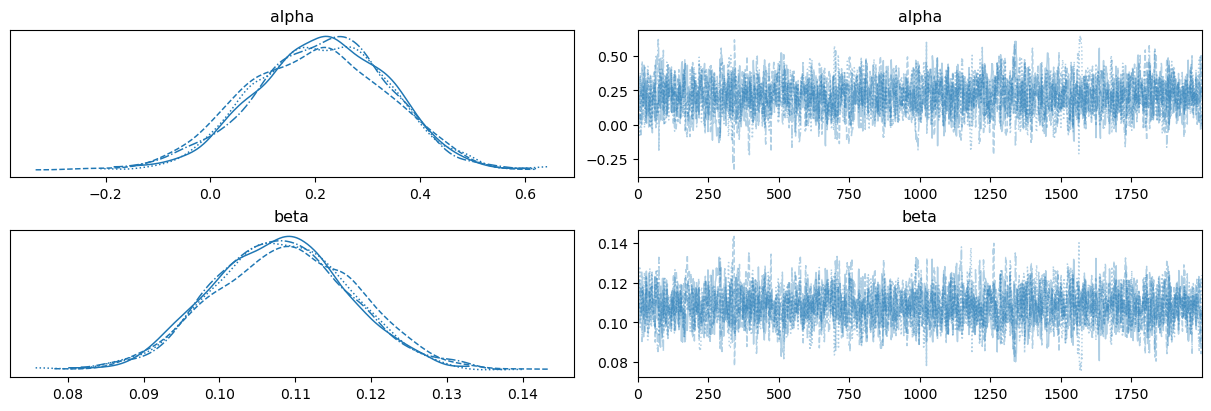

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.21  0.13   -0.03     0.45        0.0      0.0   2038.70   1987.93   
beta   0.11  0.01    0.09     0.13        0.0      0.0   2024.81   1862.98   

       r_hat  
alpha    1.0  
beta     1.0  


/home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mori/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


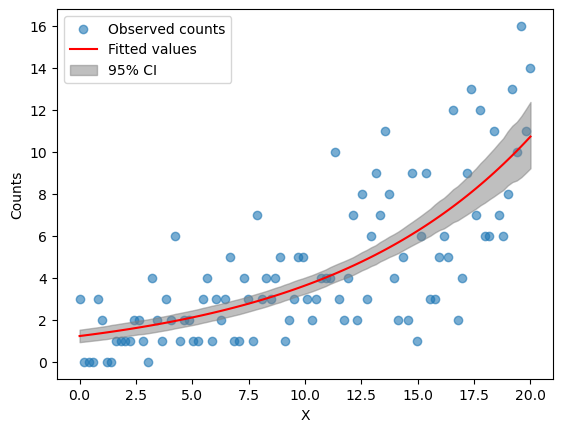

In [4]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

# 乱数のシードを固定
np.random.seed(42)

# データを生成 (先程と同じデータ)
n_samples = 100
x = np.linspace(0, 20, n_samples)
lambda_ = np.exp(0.3 + 0.1 * x)
y = np.random.poisson(lambda_)

# データフレームにまとめる
data = pd.DataFrame({'x': x, 'y': y})

# ベイズポアソン回帰モデルの設定
with pm.Model() as model:
    # 事前分布を設定（正規分布を使用）
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    
    # ポアソン分布の平均 lambda を計算
    mu = pm.math.exp(alpha + beta * data['x'])
    
    # 尤度関数を設定
    y_obs = pm.Poisson('y_obs', mu=mu, observed=data['y'])
    
    # サンプリング
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

# サンプリング結果の表示
az.plot_trace(trace)
plt.show()

# パラメータの事後分布の要約
print(az.summary(trace, round_to=2))

# 予測のプロット
plt.scatter(x, y, label='Observed counts', alpha=0.6)

# 平均予測
mu_mean = np.exp(trace['alpha'].mean() + trace['beta'].mean() * x)
plt.plot(x, mu_mean, color='red', label='Fitted values')

# 95% 信頼区間
mu_pred = np.exp(trace['alpha'][:, None] + trace['beta'][:, None] * x)
mu_hpd = az.hdi(mu_pred)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='gray', alpha=0.5, label='95% CI')

plt.xlabel('X')
plt.ylabel('Counts')
plt.legend()
plt.show()